# AutoEncoder, Variational AutoEncoder and GAN

In [1]:
import numpy as np
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from typing import Sequence
import datetime
import copy
from os import listdir
from tqdm import tqdm

## General instructions

Every two weeks you will be given an assignment related to the associated module. There are 3 weekly group sessions available to help you complete the assignments, you are invited to attend one of them each week. Attendance is not mandatory but recommended. However, assignments are graded and not submitting them or submitting them after the deadline will give you no points. The grading system is detailed [here](https://mitt.uib.no/courses/27468/pages/general-information)

**FORMAT**: Jupyter notebook    
**DEADLINE**: Sunday 16th May, 23:59

## Introduction

In this assignment we will go through 3 types of unsupervised neural network: AutoEncoder (AE), Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN). In the first section we will also introduce a new type of layer: the transpose convolution as it is widely used in these unsupervised methods.

Unsupervised have many advantages including the fact that they don't need labels but they are also harder to train... In this assignment it will be totally okay if you don't get good results, we will provide examples of expected results and we don't expect you to spend the entire 2 weeks on the parameter tuning.

## Contents

1. Transpose convolution
2. AutoEncoder
3. Variational AutoEncoder **IN ANOTHER NOTEBOOK COMING SOON**
4. GAN  **IN ANOTHER NOTEBOOK COMING SOON**

## Related videos from the curriculum

- [Lecture 15.1 — From PCA to autoencoders](https://www.youtube.com/watch?v=PSOt7u8u23w&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=69)
- [Lecture 15.2 — Deep autoencoders](https://www.youtube.com/watch?v=6jhhIPdgkp0&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=70) 
- [Lecture 15.3 — Deep autoencoders for document retrieval](https://www.youtube.com/watch?v=ZCNbjpcX0yg&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=71)
- [Lecture 15.6 — Shallow autoencoders for pre training](https://www.youtube.com/watch?v=xjlvVfEbhz4&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=74)
- [Lecture 13 | Generative Models]


## 1. Transpose convolution

**NOTE:** The next sections do not depend on this section, if you are stuck here you can move on to the section 2. :)

--------------------

In this assignment we will use a new type of layer: Transpose Convolution. This layer is typically used when we want to use a neural network to generate images (which is the case for AE, VAE and GAN). To make sure that you understand what it does we ask you to implement a simplified version of the transpose convolution operation. 

TransposeConvolution is NOT the inverse operation of convolution! In mathematics, deconvolution is the operation inverse to convolution! But in machine learning it is often said that TransposeConvolution layers are the symmetric or the inverse of the convolution layers (which is not mathematically true).  The name comes from the fact that the transposed convolution transposes the weight matrix and the input in the actual calculation process compared to the direct convolution.

Surprisingly, Andrew did not make any video about this layer. For some ressource you can check this [blog post](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8) or this [video](https://www.youtube.com/watch?v=QmCxqsbn5B0). Specifically, for an input tensor ``x`` of shape ``(N, C_in, H_in, W_in)`` and a weight tensor ``weights`` of shape ``(C_in, C_out, kernel_size[0], kernel_size[1])`` a transpose convolution layer returns  a tensor ``out`` of shape ``(N, C_out, H_out, W_out)`` (See the *shape* section of [torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d) for the formula that gives ``(H_out, W_out)``)), such that:

$$out[n, \; c_{out}, \; h_{start}:h_{end}, \; w_{start}:w_{end}] = \sum_{c_{in} = 0}^{C_{in}-1} x[n, \; c_{in}, \; h, \; w] * weights[c_{in}, \; c_{out}, \; :h_{end}-h_{start}, \; :w_{end}-w_{start}]$$

For:

- $n = 0 ... N - 1$
- $c = 0 ... C_{out} - 1$
- $h = 0 ... H_{in} - 1$
- $w = 0 ... W_{in} - 1$


With:
- $h_{start} = h*stride[0]$
- $w_{start} = w*stride[1]$
- $h_{end} = min(H_{out}, h_{start} + kernel_size[0])$
- $w_{end} = min(W_{out}, w_{start} + kernel_size[1])$

--------------------
## TODO

1. Write a ``get_output_size`` function that takes as parameter an input tensor ``x`` of shape ``(N, C_in, H_in, W_in)``, a tuple of int ``kernel_size`` and a tuple of int ``stride`` and that returns the expected output spatial shape ``(H_out, W_out)`` of the transpose convolution operation. See the *shape* section of [torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d) for the formula that gives this output shape (We ignore the padding here, so ``padding=0``)

2. Write a ``apply_transpose_conv`` function that takes as parameter an input tensor ``x`` of shape ``(N, C_in, H_in, W_in)``, a weight tensor ``weights`` of shape ``(C_in, C_out, kernel_size[0], kernel_size[1])`` and a tuple of int ``stride`` and that returns ``out``, a tensor with the right shape and containing the result of the transpose convolution operation between ``x`` and ``weights``. You are of course not allowed to use [torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d) not its functional counterpart. 

**NOTE:** We will not really use this function in practice so it's okay to use for loops for the sake of clarity and simplicity in this section

**NOTE:** You will be able to test your functions in the next cell.

In [2]:
def int_to_pair(n):
    """
    Return `(n, n)` if `n` is a int or `n` if `n` is already a tuple of length 2
    """
    # If n is a float or integer
    if not isinstance(n, Sequence):
        return (int(n), int(n))
    elif len(n) == 1:
        return (int(n[0]), int(n[0]))
    elif len(n) == 2:
        return ( int(n[0]), int(n[1]) )
    else:
        raise ValueError("Please give an int or a pair of int")

def get_output_size(x, kernel_size, stride):
    (_, _, H_in, W_in) = x.shape
    H_out = (H_in - 1) * stride[0] + (kernel_size[0] - 1) + 1
    W_out = (W_in - 1) * stride[1] + (kernel_size[1] - 1) + 1
    return (H_out, W_out)


def apply_transpose_conv(x, weights, stride):
    # stride must be pairs of int
    stride = int_to_pair(stride)

    # weights
    (_ , C_out, k_w, k_h) = weights.shape
    kernel_size = [k_w, k_h]

    # get output shape
    (N, C_in, H_in, W_in) = x.shape
    H_out, W_out = get_output_size(x, kernel_size, stride)

    # Initialize output tensor with the right shape 
    out = torch.zeros((N, C_out, H_out, W_out))

    # We will not really use this function in practice so it's okay to use 
    # for loops for the sake of clarity
    print(C_out)
    for n in range(N):
        for c in range(C_out):
            for h in range(H_in):
                for w in range(W_in):
                    h_start = h * stride[0]
                    w_start = w * stride[1]
                    h_end = min(h_start+kernel_size[0], H_out)
                    w_end = min(w_start+kernel_size[1], W_out)
                    out_i = torch.zeros(out[n, c, h_start:h_end,
                                        w_start:w_end].shape)

                    for c_in in range(C_in):
                        out_i += x[n, c_in, h, w] * weights[c_in, c, :h_end-h_start, :w_end-w_start]
                    out[n, c, h_start:h_end, w_start:w_end] += out_i
    return out

def initialize_weights(C_in, C_out, kernel_size):
    """
    Helper function for the tests in the cell below
    """
    kernel_size = int_to_pair(kernel_size)
    len_weights = C_in*C_out*kernel_size[0]*kernel_size[1]
    weights = (torch.arange(len_weights) - len_weights/2)/10
    return weights.reshape(C_in, C_out, kernel_size[0], kernel_size[1])

### Test tranpose convolution 

In [3]:
out1_exp = torch.Tensor([[[[ -30.,  -55.,  -55.,  -25.],
          [ -50.,  -90.,  -90.,  -40.],
          [ -60., -105., -105.,  -45.],
          [ -60., -105., -105.,  -45.],
          [ -30.,  -50.,  -50.,  -20.],
          [ -10.,  -15.,  -15.,   -5.]],
         [[   0.,    5.,    5.,    5.],
          [  10.,   30.,   30.,   20.],
          [  30.,   75.,   75.,   45.],
          [  30.,   75.,   75.,   45.],
          [  30.,   70.,   70.,   40.],
          [  20.,   45.,   45.,   25.]]],
        [[[ -30.,  -55.,  -55.,  -25.],
          [ -50.,  -90.,  -90.,  -40.],
          [ -60., -105., -105.,  -45.],
          [ -60., -105., -105.,  -45.],
          [ -30.,  -50.,  -50.,  -20.],
          [ -10.,  -15.,  -15.,   -5.]],
         [[   0.,    5.,    5.,    5.],
          [  10.,   30.,   30.,   20.],
          [  30.,   75.,   75.,   45.],
          [  30.,   75.,   75.,   45.],
          [  30.,   70.,   70.,   40.],
          [  20.,   45.,   45.,   25.]]]])

out2_exp = torch.Tensor([[[[ 1.87199997e+02,  3.45299988e+02,  3.44749969e+02,  1.57900024e+02],
          [ 3.15900024e+02,  5.73850037e+02,  5.72950012e+02,  2.57650024e+02],
          [ 3.86400024e+02,  6.86250122e+02,  6.85200073e+02,  2.99550049e+02],
          [ 3.84599976e+02,  6.83099976e+02,  6.82049988e+02,  2.98200073e+02],
          [ 1.99200012e+02,  3.41249969e+02,  3.40749939e+02,  1.41950043e+02],
          [ 7.10999832e+01,  1.13749985e+02,  1.13599983e+02,  4.26499939e+01]],
         [[ 1.43999786e+01,  1.52587891e-05,  5.00183105e-02, -1.43000031e+01],
          [-2.87999954e+01, -1.14950035e+02, -1.14650032e+02, -8.58500290e+01],
          [-1.29299973e+02, -3.44249939e+02, -3.43500000e+02, -2.14350006e+02],
          [-1.28399994e+02, -3.42000000e+02, -3.41250000e+02, -2.13000031e+02],
          [-1.41899979e+02, -3.40349976e+02, -3.39650024e+02, -1.97949997e+02],
          [-9.90000000e+01, -2.26150009e+02, -2.25700012e+02, -1.26849998e+02]]],

        [[[ 1.69199982e+02,  3.12300018e+02,  3.11750061e+02,  1.42900024e+02],
          [ 2.85900024e+02,  5.19850098e+02,  5.18950012e+02,  2.33649994e+02],
          [ 3.50400024e+02,  6.23250000e+02,  6.22200012e+02,  2.72549988e+02],
          [ 3.48599945e+02,  6.20099854e+02,  6.19049927e+02,  2.71200012e+02],
          [ 1.81199982e+02,  3.11250031e+02,  3.10750000e+02,  1.29949997e+02],
          [ 6.50999985e+01,  1.04750008e+02,  1.04599998e+02,  3.96500015e+01]],

         [[ 1.44000015e+01,  3.00000763e+00,  3.05000305e+00, -1.12999954e+01],
          [-2.27999954e+01, -9.69499969e+01, -9.66499939e+01, -7.38500214e+01],
          [-1.11299980e+02, -2.99249939e+02, -2.98500031e+02, -1.87350037e+02],
          [-1.10399994e+02, -2.97000000e+02, -2.96250000e+02, -1.86000031e+02],
          [-1.23899971e+02, -2.98350037e+02, -2.97650024e+02, -1.73950012e+02],
          [-8.69999924e+01, -1.99150024e+02, -1.98700012e+02, -1.11850006e+02]]]])
N = 2
H_in = 4
W_in = 3
C_in = 5
C_out = 2

kernel_size = (3,2)
stride = 1

weights = initialize_weights(C_in, C_out, kernel_size)
x1 = torch.ones((N, C_in, H_in, W_in))*10
x2 = torch.arange(120).reshape(N, C_in, H_in, W_in)/10 - 60

print("weights.shape:  ", weights.shape)
print("x.shape:        ", x1.shape)
print("shape expected: ", out1_exp.shape)

out1 = apply_transpose_conv(x1, weights, stride)
print("out1.shape:     ", out1.shape)
out2 = apply_transpose_conv(x2, weights, stride)
print("out2.shape:     ", out2.shape)

print("\nout1 - out1_exp:\n ", out1 - out1_exp)
print("\nout2 - out2_exp:\n ", out2 - out2_exp)

weights.shape:   torch.Size([5, 2, 3, 2])
x.shape:         torch.Size([2, 5, 4, 3])
shape expected:  torch.Size([2, 2, 6, 4])
2
out1.shape:      torch.Size([2, 2, 6, 4])
2
out2.shape:      torch.Size([2, 2, 6, 4])

out1 - out1_exp:
  tensor([[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],


        [[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]]])

out2 - out2_exp:
  tensor([[[[ 0.0000e+00,  0.0000e+00,  3.0518e-05,  0.0000e+00],

# 2. AutoEncoder

*related videos from the curriculum*

- [Lecture 15.1 — From PCA to autoencoders](https://www.youtube.com/watch?v=PSOt7u8u23w&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=69)
- [Lecture 15.2 — Deep autoencoders](https://www.youtube.com/watch?v=6jhhIPdgkp0&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=70) 
- [Lecture 15.3 — Deep autoencoders for document retrieval](https://www.youtube.com/watch?v=ZCNbjpcX0yg&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=71)
- [Lecture 15.6 — Shallow autoencoders for pre training](https://www.youtube.com/watch?v=xjlvVfEbhz4&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=74)
- [Lecture 13 | Generative Models](https://www.youtube.com/watch?v=5WoItGTWV54&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=17) (from 20:40 to 27:05)

An AutoEncoder (AE) is a neural network that is composed of 2 sub-networks: an Encoder and a Decoder. AE can have many purposes but commonly the main objective is to efficiently represent the data that lies on a non-linear manifold. From this point of view, the AutoEncoder can be seen as a generalization of PCA for data that lies on non-linear manifolds as explained in this [video](https://www.youtube.com/watch?v=PSOt7u8u23w&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=69) of the curriculum.

If this is the objective then the Decoder part can be thrown away once the training is done and we can simply use the encoder part to project the data into a latent space of lower dimension ``z_dim`` (in this section, ``z_dim`` will typically be 15 or 30 while the images are 20x20 (=400)). Indeed the Decoder is here just to make sure that the encoding is well done and ensure and faithful representation of the data by comparing the reconstructed (i.e decoded) instances of the compressed (i.e encoded) data with the original data.

### Modules 

In the cell below are defined the following modules that we will need in this section

1. **MyEncoder**
    - input: image
    - output: tensor `z` in latent space (lower dimension than input space)
1. **MyDecoder**
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: reconstructed image
1. **MyAE**
    - input: image
    - output reconstructed image after reduction to latent space
    - attributes:
      - self.encoder = MyEncoder(z_dim)
      - self.decoder = MyDecoder(z_dim)
1. **LeNet5ish**
    Regular image classifier
    - input: image
    - output: label predicted
1. **MyClassifier**
    Classifier on compressed images:
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: label predicted

--------------------
## TODO

1. Take a look at the ``MyEncoder``, ``MyDecoder`` and ``MyAE`` modules. Do the Encoder and Decoder seem really different from any other neural networks so far?


In [4]:
class MyEncoder(nn.Module):
    """
    Encoder module: 
    - input: image
    - output: tensor `z` in latent space (lower dimension than input space)
    """

    def __init__(self, z_dim):
        super().__init__() 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=6, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=5, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=4, kernel_size=4, stride=1)
        self.fc3 = nn.Linear(in_features=256, out_features=z_dim)
        
    def forward(self, x):
        N = x.shape[0]
        out = torch.relu(self.conv1(x))
        out = torch.relu(self.conv2(out))
        out = torch.relu(self.conv3(out))
        out = out.view(N, -1)
        out = torch.relu(self.fc3(out))
        return out

class MyDecoder(nn.Module):
    """
    Decoder module: 
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: reconstructed image
    """
    def __init__(self, z_dim):
        super().__init__() 
        c1 = 3
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 18*18)
        self.transconv3 = nn.ConvTranspose2d(in_channels=1, out_channels=1,  kernel_size=3, stride=1)
        
        
    def forward(self, x):
        N, z_dim = x.shape
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = out.view(N, 1, 18, 18)
        out = torch.sigmoid(self.transconv3(out))
        return out

class MyAE(nn.Module):
    """
    AutoEncoder
    - input: image
    - output reconstructed image after reduction to latent space

    attributes
    - self.encoder = MyEncoder(z_dim)
    - self.decoder = MyDecoder(z_dim)
    """

    def __init__(self, z_dim):
        super().__init__() 
        self.encoder = MyEncoder(z_dim)
        self.decoder = MyDecoder(z_dim)
        
    def forward(self, x):
        self.z = self.encoder(x)
        out = self.decoder(self.z)
        return out


class LeNet5ish(nn.Module):
    """
    Regular image classifier
    - input: image
    - output: label predicted
    """

    def __init__(self, n_labels=10):
        super().__init__() 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=6, kernel_size=5, stride=1)
        self.fc3 = nn.Linear(in_features=864, out_features=120)
        self.fc4 = nn.Linear(in_features=120, out_features=n_labels)
        
    def forward(self, x):
        N = x.shape[0]
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(N, -1)
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        return out

class MyClassifier(nn.Module):
    """
    Classifier on compressed images:
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: label predicted
    """

    def __init__(self, z_dim, n_labels=10):
        super().__init__() 
        c1 = 12
        self.fc1 = nn.Linear(z_dim, 64)
        self.transconv1 = nn.ConvTranspose2d(in_channels=1,  out_channels=c1, kernel_size=3, stride=1)
        self.transconv2 = nn.ConvTranspose2d(in_channels=c1, out_channels=1,  kernel_size=3, stride=1)
        self.fc2 = nn.Linear(144, n_labels)
        
    def forward(self, x):
        N, z_dim = x.shape
        out = F.relu(self.fc1(x))
        out = out.view(N, 1, 8, 8)
        out = F.relu(self.transconv1(out)) 
        out = F.relu(self.transconv2(out))
        out = out.view(N, -1)
        out = F.relu(self.fc2(out))
        return out





### Utils 

Some useful functions:

- **load_MNIST**: Return MNIST train and val dataset
- **training_classifier**: Usual training loop for a classifier
- **validate**: Compute classification accuracies on both train and val dataset
- **plot_true_VS_reconstructed**: Plot side by side original images with their reconstructed counterparts using a trained AE

In [5]:
preprocessor = transforms.Compose([
    transforms.CenterCrop(20),
    transforms.ToTensor(),
    transforms.Normalize(0.2475, 0.3892),
]) 


def load_MNIST(data_path='../data/', transform = preprocessor, labels_kept=[0,1,3,4,8]):
    """
    Return MNIST train and val dataset
    """
    MNIST_train = datasets.MNIST(
        data_path,       
        train=True,      
        download=True,   
        transform=transform
    )

    MNIST_val = datasets.MNIST(
        data_path, 
        train=False,      
        download=True,   
        transform=transform
    )

    print('Size of the original training dataset: ', len(MNIST_train))
    print('Size of the original validation dataset: ', len(MNIST_val))

    if len(labels_kept) <10:
        MNIST_train_reduced = [(img, labels_kept.index(label)) for img, label in MNIST_train if label in labels_kept]
        MNIST_val_reduced = [(img, labels_kept.index(label)) for img, label in MNIST_val if label in labels_kept]

        print('Size of the reduced training dataset: ', len(MNIST_train_reduced))
        print('Size of the reduced validation dataset: ', len(MNIST_val_reduced))
    else:
        MNIST_train_reduced = MNIST_train
        MNIST_val_reduced = MNIST_val

    return MNIST_train_reduced, MNIST_val_reduced


def training_classifier(n_epochs, optimizer, model, loss_fn, train_loader, device=None):
    """
    Usual training loop for a classifier
    """
    if device is None:
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs = imgs.to(device=device) 
            labels = labels.to(device=device) 
            batch_size = imgs.shape[0]
            with torch.cuda.amp.autocast(enabled=True):

                outputs = model(imgs)
                loss = loss_fn(outputs, labels)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                loss_train += loss.item()

        if epoch == 1 or epoch % 1 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


def validate(model, train_loader, val_loader):
    """
    Compute classification accuracies on both train and val dataset
    """
    accdict = {}
    model.eval()
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

def plot_true_VS_reconstructed(ae, imgs):
    """
    Plot side by side original images with their reconstructed counterpart using a trained AE
    """
    ae.eval()
    N_img = 25
    fig, axs = plt.subplots(nrows=5, ncols=10, figsize=(10,6), sharex=True, sharey=True)
    for i, img in enumerate(imgs[:N_img]):
        with torch.no_grad():
            out = ae(img.unsqueeze(0))
            # True image
            axs.flat[2*i].imshow(img.permute(1, 2, 0), cmap='Greys')
            # Reconstruction
            axs.flat[2*i + 1].imshow(out.squeeze(0).permute(1, 2, 0), cmap='Greys') 
            # Set ax title for the first row
            if i<5:
                axs.flat[2*i].set_title("True\nimage")
                axs.flat[2*i + 1].set_title("AE recon-\nstruction")
    return fig, axs




In [6]:
# Load the data

labels_kept = [i for i in range(10)]
data_train, data_val = load_MNIST(labels_kept=labels_kept)
imgs_train = [img for img, _ in data_train]
label_train = [label for _, label in data_train]
imgs_val = [img for img, _ in data_val]
label_val = [label for _, label in data_val]

Size of the original training dataset:  60000
Size of the original validation dataset:  10000


### Training loop of an AutoEncoder

--------------------
## TODO

1. Write a function ``training_ae`` (you can get inspired by the ``training_classifier`` function in the utils cell above) that trains an auto-encoder. The objective is that the encoder part of the AE gets good at summarizing the data in the latent space and that the decoder gets good at reconstructing the images from the lower dimensional vectors in the latent space.

Note that:
- There is no label in the dataset (so no label in ``train_loader`` neither)
- The loss function is computed by comparing the outputs with the original images. We will typically call this function with loss_fn = `` nn.MSELoss()`` so that each reconstructed pixel is compared to its original couterpart.

In [7]:
def training_ae(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, device=None):
    """
    Train an AE. No labels required
    """
    if device is None:
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_bar = tqdm(total=len(train_loader), desc="Epoch progression")
        loss_train = 0.0
        for imgs in train_loader:

            imgs = imgs.to(device=device)
            batch_size = imgs.shape[0]
            with torch.cuda.amp.autocast(enabled=True):

                outputs = model(imgs)
                loss = loss_fn(outputs, imgs)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                loss_train += loss.item()
            train_bar.update()
        if epoch == 1 or epoch % 1 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
        train_bar.close()

        model.eval()
        loss_eval = 0.0
        with torch.no_grad():
            for imgs in val_loader:
                imgs = imgs.to(device=device)
                with torch.cuda.amp.autocast(enabled=True):

                    outputs = model(imgs)
                    loss = loss_fn(outputs, imgs)
                    loss_eval += loss.item()
        print('{}  |  Epoch {}  |  Validation loss {:.3f}'.format(
    datetime.datetime.now(), epoch,
    loss_eval / len(val_loader)))

### Training your AutoEncoder

Run the cell below to train your AE. You can play with the parameter if you want/need.
Keep in mind that training unsupervised model is not easy and that it is okay in this assignment if you don't get good results at all, we will provide examples of results so that you can still answer the questions).
For this assignment (and in its specific settings) we can say that your AE learns well if your training loss is lower than 0.6. 

In [8]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")
z_dim = 15

ae = MyAE(z_dim=z_dim)
ae.to(device=device)

train_loader_imgs = torch.utils.data.DataLoader(imgs_train, batch_size=512, shuffle=True)
val_loader_imgs = torch.utils.data.DataLoader(imgs_val, batch_size=512, shuffle=True)

lr = 0.5
momentum = 0.6

optimizer = optim.SGD(ae.parameters(), lr=lr, momentum=momentum)
loss_fn = nn.MSELoss()

training_ae(
    n_epochs = 80,
    optimizer = optimizer,
    model = ae,
    loss_fn = loss_fn,
    train_loader = train_loader_imgs,
    val_loader = val_loader_imgs
)

Training on device cuda.


Epoch progression:  15%|█▌        | 18/118 [00:00<00:00, 178.06it/s]

2021-05-14 09:43:01.732564  |  Epoch 1  |  Training loss 1.014
2021-05-14 09:43:01.761591  |  Epoch 1  |  Validation loss 1.015


Epoch progression:  16%|█▌        | 19/118 [00:00<00:00, 188.45it/s]

2021-05-14 09:43:02.402172  |  Epoch 2  |  Training loss 1.002
2021-05-14 09:43:02.430197  |  Epoch 2  |  Validation loss 1.014


Epoch progression:  16%|█▌        | 19/118 [00:00<00:00, 189.83it/s]

2021-05-14 09:43:03.035479  |  Epoch 3  |  Training loss 1.000
2021-05-14 09:43:03.064505  |  Epoch 3  |  Validation loss 1.013


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 134.49it/s]

2021-05-14 09:43:03.763139  |  Epoch 4  |  Training loss 0.995
2021-05-14 09:43:03.795169  |  Epoch 4  |  Validation loss 0.918


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 139.87it/s]

2021-05-14 09:43:04.625923  |  Epoch 5  |  Training loss 0.794
2021-05-14 09:43:04.658953  |  Epoch 5  |  Validation loss 0.720


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 135.80it/s]

2021-05-14 09:43:05.494712  |  Epoch 6  |  Training loss 0.679
2021-05-14 09:43:05.525740  |  Epoch 6  |  Validation loss 0.648


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 138.49it/s]

2021-05-14 09:43:06.348487  |  Epoch 7  |  Training loss 0.640
2021-05-14 09:43:06.383519  |  Epoch 7  |  Validation loss 0.625


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 134.49it/s]

2021-05-14 09:43:07.189251  |  Epoch 8  |  Training loss 0.616
2021-05-14 09:43:07.220279  |  Epoch 8  |  Validation loss 0.614


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 131.96it/s]

2021-05-14 09:43:08.044027  |  Epoch 9  |  Training loss 0.599
2021-05-14 09:43:08.078059  |  Epoch 9  |  Validation loss 0.591


Epoch progression:  11%|█         | 13/118 [00:00<00:00, 127.34it/s]

2021-05-14 09:43:08.906810  |  Epoch 10  |  Training loss 0.587
2021-05-14 09:43:08.944845  |  Epoch 10  |  Validation loss 0.586


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 137.13it/s]

2021-05-14 09:43:09.795617  |  Epoch 11  |  Training loss 0.575
2021-05-14 09:43:09.827646  |  Epoch 11  |  Validation loss 0.568


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 138.49it/s]

2021-05-14 09:43:10.671412  |  Epoch 12  |  Training loss 0.568
2021-05-14 09:43:10.703442  |  Epoch 12  |  Validation loss 0.566


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 135.80it/s]

2021-05-14 09:43:11.532194  |  Epoch 13  |  Training loss 0.561
2021-05-14 09:43:11.564223  |  Epoch 13  |  Validation loss 0.561


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 159.85it/s]

2021-05-14 09:43:12.346934  |  Epoch 14  |  Training loss 0.557
2021-05-14 09:43:12.375960  |  Epoch 14  |  Validation loss 0.560


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:13.096116  |  Epoch 15  |  Training loss 0.553
2021-05-14 09:43:13.124142  |  Epoch 15  |  Validation loss 0.551


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:13.839791  |  Epoch 16  |  Training loss 0.549
2021-05-14 09:43:13.867817  |  Epoch 16  |  Validation loss 0.552


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 159.85it/s]

2021-05-14 09:43:14.585469  |  Epoch 17  |  Training loss 0.546
2021-05-14 09:43:14.614495  |  Epoch 17  |  Validation loss 0.556


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 161.76it/s]

2021-05-14 09:43:15.333147  |  Epoch 18  |  Training loss 0.544
2021-05-14 09:43:15.362360  |  Epoch 18  |  Validation loss 0.563


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:16.077009  |  Epoch 19  |  Training loss 0.541
2021-05-14 09:43:16.107036  |  Epoch 19  |  Validation loss 0.563


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 159.86it/s]

2021-05-14 09:43:16.823687  |  Epoch 20  |  Training loss 0.540
2021-05-14 09:43:16.852713  |  Epoch 20  |  Validation loss 0.540


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 161.76it/s]

2021-05-14 09:43:17.569365  |  Epoch 21  |  Training loss 0.538
2021-05-14 09:43:17.598390  |  Epoch 21  |  Validation loss 0.547


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 158.27it/s]

2021-05-14 09:43:18.315042  |  Epoch 22  |  Training loss 0.536
2021-05-14 09:43:18.344068  |  Epoch 22  |  Validation loss 0.536


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 161.76it/s]

2021-05-14 09:43:19.067725  |  Epoch 23  |  Training loss 0.535
2021-05-14 09:43:19.096751  |  Epoch 23  |  Validation loss 0.554


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 164.90it/s]

2021-05-14 09:43:19.825413  |  Epoch 24  |  Training loss 0.534
2021-05-14 09:43:19.853438  |  Epoch 24  |  Validation loss 0.532


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:20.574092  |  Epoch 25  |  Training loss 0.532
2021-05-14 09:43:20.603119  |  Epoch 25  |  Validation loss 0.557


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.32it/s]

2021-05-14 09:43:21.378823  |  Epoch 26  |  Training loss 0.531
2021-05-14 09:43:21.407849  |  Epoch 26  |  Validation loss 0.534


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 159.86it/s]

2021-05-14 09:43:22.152525  |  Epoch 27  |  Training loss 0.530
2021-05-14 09:43:22.180551  |  Epoch 27  |  Validation loss 0.531


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:22.903207  |  Epoch 28  |  Training loss 0.529
2021-05-14 09:43:22.932233  |  Epoch 28  |  Validation loss 0.529


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:23.645881  |  Epoch 29  |  Training loss 0.528
2021-05-14 09:43:23.673907  |  Epoch 29  |  Validation loss 0.538


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 159.86it/s]

2021-05-14 09:43:24.390558  |  Epoch 30  |  Training loss 0.527
2021-05-14 09:43:24.418583  |  Epoch 30  |  Validation loss 0.528


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:25.140238  |  Epoch 31  |  Training loss 0.527
2021-05-14 09:43:25.168263  |  Epoch 31  |  Validation loss 0.537


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 161.76it/s]

2021-05-14 09:43:25.897926  |  Epoch 32  |  Training loss 0.525
2021-05-14 09:43:25.925951  |  Epoch 32  |  Validation loss 0.524


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:26.643603  |  Epoch 33  |  Training loss 0.525
2021-05-14 09:43:26.671629  |  Epoch 33  |  Validation loss 0.526


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:27.388279  |  Epoch 34  |  Training loss 0.524
2021-05-14 09:43:27.417306  |  Epoch 34  |  Validation loss 0.532


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.32it/s]

2021-05-14 09:43:28.132956  |  Epoch 35  |  Training loss 0.523
2021-05-14 09:43:28.160981  |  Epoch 35  |  Validation loss 0.536


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 161.76it/s]

2021-05-14 09:43:28.875630  |  Epoch 36  |  Training loss 0.522
2021-05-14 09:43:28.903656  |  Epoch 36  |  Validation loss 0.524


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 159.86it/s]

2021-05-14 09:43:29.619305  |  Epoch 37  |  Training loss 0.522
2021-05-14 09:43:29.648332  |  Epoch 37  |  Validation loss 0.520


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.32it/s]

2021-05-14 09:43:30.362988  |  Epoch 38  |  Training loss 0.522
2021-05-14 09:43:30.392015  |  Epoch 38  |  Validation loss 0.519


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 158.27it/s]

2021-05-14 09:43:31.104661  |  Epoch 39  |  Training loss 0.521
2021-05-14 09:43:31.132688  |  Epoch 39  |  Validation loss 0.523


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.32it/s]

2021-05-14 09:43:31.850339  |  Epoch 40  |  Training loss 0.521
2021-05-14 09:43:31.879366  |  Epoch 40  |  Validation loss 0.531


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 158.27it/s]

2021-05-14 09:43:32.609028  |  Epoch 41  |  Training loss 0.520
2021-05-14 09:43:32.638055  |  Epoch 41  |  Validation loss 0.529


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 161.76it/s]

2021-05-14 09:43:33.358708  |  Epoch 42  |  Training loss 0.520
2021-05-14 09:43:33.387735  |  Epoch 42  |  Validation loss 0.526


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 161.76it/s]

2021-05-14 09:43:34.103384  |  Epoch 43  |  Training loss 0.519
2021-05-14 09:43:34.131410  |  Epoch 43  |  Validation loss 0.519


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 161.76it/s]

2021-05-14 09:43:34.848060  |  Epoch 44  |  Training loss 0.519
2021-05-14 09:43:34.877087  |  Epoch 44  |  Validation loss 0.522


Epoch progression:  11%|█         | 13/118 [00:00<00:00, 126.10it/s]

2021-05-14 09:43:35.672312  |  Epoch 45  |  Training loss 0.519
2021-05-14 09:43:35.704341  |  Epoch 45  |  Validation loss 0.522


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 137.13it/s]

2021-05-14 09:43:36.541101  |  Epoch 46  |  Training loss 0.517
2021-05-14 09:43:36.573130  |  Epoch 46  |  Validation loss 0.518


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 138.49it/s]

2021-05-14 09:43:37.423902  |  Epoch 47  |  Training loss 0.517
2021-05-14 09:43:37.457934  |  Epoch 47  |  Validation loss 0.527


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 156.72it/s]

2021-05-14 09:43:38.253656  |  Epoch 48  |  Training loss 0.517
2021-05-14 09:43:38.282682  |  Epoch 48  |  Validation loss 0.521


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 156.72it/s]

2021-05-14 09:43:39.033364  |  Epoch 49  |  Training loss 0.517
2021-05-14 09:43:39.062390  |  Epoch 49  |  Validation loss 0.517


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 137.13it/s]

2021-05-14 09:43:39.818077  |  Epoch 50  |  Training loss 0.516
2021-05-14 09:43:39.854109  |  Epoch 50  |  Validation loss 0.516


Epoch progression:  13%|█▎        | 15/118 [00:00<00:00, 141.38it/s]

2021-05-14 09:43:40.689868  |  Epoch 51  |  Training loss 0.516
2021-05-14 09:43:40.724900  |  Epoch 51  |  Validation loss 0.516


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:41.494599  |  Epoch 52  |  Training loss 0.515
2021-05-14 09:43:41.522624  |  Epoch 52  |  Validation loss 0.525


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:42.240276  |  Epoch 53  |  Training loss 0.515
2021-05-14 09:43:42.269302  |  Epoch 53  |  Validation loss 0.517


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 133.21it/s]

2021-05-14 09:43:42.990957  |  Epoch 54  |  Training loss 0.515
2021-05-14 09:43:43.025989  |  Epoch 54  |  Validation loss 0.523


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 158.27it/s]

2021-05-14 09:43:43.794687  |  Epoch 55  |  Training loss 0.515
2021-05-14 09:43:43.827717  |  Epoch 55  |  Validation loss 0.518


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 153.71it/s]

2021-05-14 09:43:44.592412  |  Epoch 56  |  Training loss 0.514
2021-05-14 09:43:44.624441  |  Epoch 56  |  Validation loss 0.514


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 159.47it/s]

2021-05-14 09:43:45.361109  |  Epoch 57  |  Training loss 0.514
2021-05-14 09:43:45.391137  |  Epoch 57  |  Validation loss 0.515


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 137.13it/s]

2021-05-14 09:43:46.151332  |  Epoch 58  |  Training loss 0.514
2021-05-14 09:43:46.184361  |  Epoch 58  |  Validation loss 0.523


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 138.49it/s]

2021-05-14 09:43:46.964069  |  Epoch 59  |  Training loss 0.514
2021-05-14 09:43:46.998100  |  Epoch 59  |  Validation loss 0.522


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 138.49it/s]

2021-05-14 09:43:47.784814  |  Epoch 60  |  Training loss 0.513
2021-05-14 09:43:47.817844  |  Epoch 60  |  Validation loss 0.518


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 161.76it/s]

2021-05-14 09:43:48.587543  |  Epoch 61  |  Training loss 0.512
2021-05-14 09:43:48.616569  |  Epoch 61  |  Validation loss 0.516


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 159.86it/s]

2021-05-14 09:43:49.375258  |  Epoch 62  |  Training loss 0.512
2021-05-14 09:43:49.403284  |  Epoch 62  |  Validation loss 0.516


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 161.76it/s]

2021-05-14 09:43:50.122937  |  Epoch 63  |  Training loss 0.512
2021-05-14 09:43:50.152964  |  Epoch 63  |  Validation loss 0.522


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:50.871617  |  Epoch 64  |  Training loss 0.512
2021-05-14 09:43:50.900644  |  Epoch 64  |  Validation loss 0.514


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 158.27it/s]

2021-05-14 09:43:51.620297  |  Epoch 65  |  Training loss 0.512
2021-05-14 09:43:51.648323  |  Epoch 65  |  Validation loss 0.513


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 159.86it/s]

2021-05-14 09:43:52.377985  |  Epoch 66  |  Training loss 0.511
2021-05-14 09:43:52.406011  |  Epoch 66  |  Validation loss 0.511


Epoch progression:  12%|█▏        | 14/118 [00:00<00:00, 139.87it/s]

2021-05-14 09:43:53.183717  |  Epoch 67  |  Training loss 0.511
2021-05-14 09:43:53.216747  |  Epoch 67  |  Validation loss 0.516


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 156.72it/s]

2021-05-14 09:43:53.975436  |  Epoch 68  |  Training loss 0.511
2021-05-14 09:43:54.007465  |  Epoch 68  |  Validation loss 0.515


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:54.731121  |  Epoch 69  |  Training loss 0.511
2021-05-14 09:43:54.760149  |  Epoch 69  |  Validation loss 0.515


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.32it/s]

2021-05-14 09:43:55.477799  |  Epoch 70  |  Training loss 0.511
2021-05-14 09:43:55.506827  |  Epoch 70  |  Validation loss 0.511


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 159.86it/s]

2021-05-14 09:43:56.224477  |  Epoch 71  |  Training loss 0.510
2021-05-14 09:43:56.252503  |  Epoch 71  |  Validation loss 0.512


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:57.007188  |  Epoch 72  |  Training loss 0.510
2021-05-14 09:43:57.036214  |  Epoch 72  |  Validation loss 0.517


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 156.72it/s]

2021-05-14 09:43:57.755868  |  Epoch 73  |  Training loss 0.510
2021-05-14 09:43:57.784894  |  Epoch 73  |  Validation loss 0.513


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 163.31it/s]

2021-05-14 09:43:58.507550  |  Epoch 74  |  Training loss 0.509
2021-05-14 09:43:58.537577  |  Epoch 74  |  Validation loss 0.509


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 156.72it/s]

2021-05-14 09:43:59.256230  |  Epoch 75  |  Training loss 0.509
2021-05-14 09:43:59.285256  |  Epoch 75  |  Validation loss 0.510


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 159.86it/s]

2021-05-14 09:44:00.071970  |  Epoch 76  |  Training loss 0.509
2021-05-14 09:44:00.100997  |  Epoch 76  |  Validation loss 0.508


Epoch progression:  14%|█▍        | 17/118 [00:00<00:00, 161.76it/s]

2021-05-14 09:44:00.853681  |  Epoch 77  |  Training loss 0.509
2021-05-14 09:44:00.884709  |  Epoch 77  |  Validation loss 0.513


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 159.86it/s]

2021-05-14 09:44:01.606364  |  Epoch 78  |  Training loss 0.509
2021-05-14 09:44:01.635390  |  Epoch 78  |  Validation loss 0.511


Epoch progression:  14%|█▎        | 16/118 [00:00<00:00, 159.86it/s]

2021-05-14 09:44:02.356045  |  Epoch 79  |  Training loss 0.509
2021-05-14 09:44:02.384070  |  Epoch 79  |  Validation loss 0.514


Epoch progression: 100%|██████████| 118/118 [00:00<00:00, 159.53it/s]

2021-05-14 09:44:03.124743  |  Epoch 80  |  Training loss 0.508
2021-05-14 09:44:03.154770  |  Epoch 80  |  Validation loss 0.518


### Plot original images VS reconstruction

--------------------
## TODO

Analyse your results (regardless of how good/bad they might be)

1. Are you satisfied by the reconstructions? If not, what seems to be the problem? Mode collapse? Overfitting? Underfitting? 

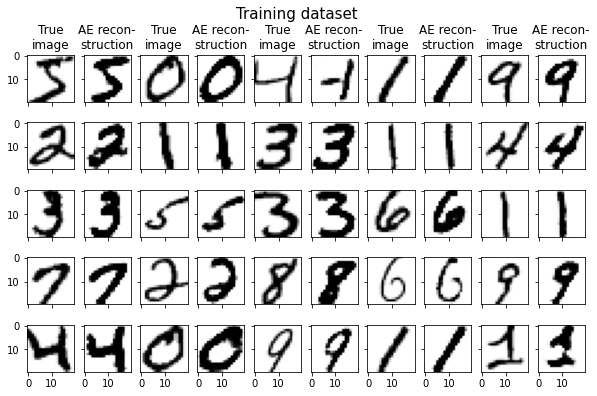

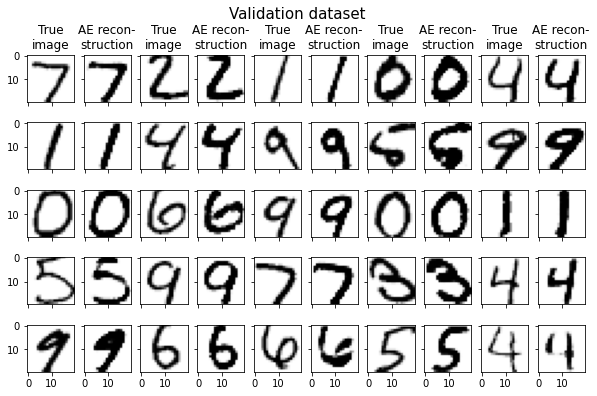

In [9]:
ae.to(device=torch.device('cpu')) 
fig, axs = plot_true_VS_reconstructed(ae, imgs_train)
fig.suptitle("Training dataset", fontsize=15)
plt.show()
fig, axs = plot_true_VS_reconstructed(ae, imgs_val)
fig.suptitle("Validation dataset", fontsize=15)
plt.show()



![Example of AE results on the validation dataset (see train01 image)](./train01.png)


--------------------
## TODO
Analyse the results in the image above.

1. Without looking at the true image, would you say that the reconstructed image looks good?
1. Now take a closer look at the bottom right pair. What can you say? 

### Compress images using the Encoder part of our trained AE

--------------------
## TODO


1. Use the ``transform_images`` function defined in the cell below to compress ``train_loader_imgs`` and ``val_loader_imgs`` and store them in ``compressed_imgs_train`` and ``compressed_imgs_val``. To do so call the function with the encoder part of our AE (accessible using ``ae.encoder``)
2. We have divided by more than 10 the size of the original data, cite some obvious advantages of this compression. 
3. Recalling this [video](https://www.youtube.com/watch?v=ZCNbjpcX0yg&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=71), this other [video](https://www.youtube.com/watch?v=xjlvVfEbhz4&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=74) and this [lecture](https://www.youtube.com/watch?v=5WoItGTWV54&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=16) (from 20:40 to 27:05 ) from the curriculum and the exercise "*CNN: visualization and interpretation, section 3. Last layer: Nearest neighbors*", what could be another application of these compressed data?

In [10]:
def transform_images(model, dataloader, device=None):
    """
    Apply ``model`` to ``dataloader`` and returns the output 
    """
    if device is None:
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model.eval()
    transformed_imgs = []
    for imgs in dataloader:
        with torch.no_grad():
            imgs = imgs.to(device=device) 
            outputs = model(imgs)
            transformed_imgs.append(outputs.clone().detach())
    transformed_imgs = torch.cat(transformed_imgs)
    return transformed_imgs


ae.to(device=device)

train_loader_imgs = torch.utils.data.DataLoader(imgs_train, batch_size=256, shuffle=False) # Keep shuffle to False here otherwise imgs won't correspond to labels anymore
val_loader_imgs = torch.utils.data.DataLoader(imgs_val, batch_size=256, shuffle=False)     # Keep shuffle to False here otherwise imgs won't correspond to labels anymore

# Use the encoder part of our ae to compress our images
compressed_imgs_train = transform_images(ae.encoder, train_loader_imgs)
compressed_imgs_val = transform_images(ae.encoder, val_loader_imgs)

# Re-associate compressed images with their corresponding labels
data_compressed_train = list(zip(compressed_imgs_train, label_train))
data_compressed_val = list(zip(compressed_imgs_val, label_val))

### Classification on compressed images

In the cell below we train ``MyClassifier`` (defined in the "Modules" subsection at the beginning of this section), a classifier that takes as input a tensor `z` in the latent space (lower dimension than the image space) and find the label corresponding to the original image.

In the next cell we evaluate the performance of our classifier.

--------------------
## TODO

1. Recalling that we started from 20x20 (=400) images that were compressed into a 15 dimensional space, are you satisfied by the classification performance? 

In [11]:
print(f"Training on device {device}.")
epoch = 60
momentum = 0.
lr=0.1


train_loader_compressed = torch.utils.data.DataLoader(data_compressed_train, batch_size=512, shuffle=True)
val_loader_compressed = torch.utils.data.DataLoader(data_compressed_val, batch_size=512, shuffle=True)

classifier_compressed = MyClassifier(z_dim=z_dim, n_labels=len(labels_kept))
classifier_compressed.to(device=device) 
optimizer = optim.SGD(classifier_compressed.parameters(), lr=lr, momentum=momentum)

loss_fn = nn.CrossEntropyLoss()

print(" ============== Training Classifier on compressed images ============== ")
training_classifier(
    n_epochs = epoch,
    optimizer = optimizer,
    model = classifier_compressed,
    loss_fn = loss_fn,
    train_loader = train_loader_compressed,
    device=device,
)


Training on device cuda.
 ============== Training Classifier on compressed images ============== 
2021-05-14 09:44:07.414645  |  Epoch 1  |  Training loss 2.267
2021-05-14 09:44:07.651860  |  Epoch 2  |  Training loss 2.295
2021-05-14 09:44:07.890076  |  Epoch 3  |  Training loss 2.088
2021-05-14 09:44:08.128293  |  Epoch 4  |  Training loss 1.537
2021-05-14 09:44:08.364507  |  Epoch 5  |  Training loss 1.219
2021-05-14 09:44:08.601723  |  Epoch 6  |  Training loss 1.124
2021-05-14 09:44:08.835935  |  Epoch 7  |  Training loss 1.064
2021-05-14 09:44:09.072150  |  Epoch 8  |  Training loss 1.027
2021-05-14 09:44:09.327381  |  Epoch 9  |  Training loss 1.001
2021-05-14 09:44:09.599629  |  Epoch 10  |  Training loss 0.977
2021-05-14 09:44:09.852859  |  Epoch 11  |  Training loss 0.963
2021-05-14 09:44:10.116098  |  Epoch 12  |  Training loss 0.940
2021-05-14 09:44:10.354314  |  Epoch 13  |  Training loss 0.919
2021-05-14 09:44:10.588527  |  Epoch 14  |  Training loss 0.747
2021-05-14 09:4

In [12]:
print(" ============== Classification on compressed images ============== ")
_ = validate(
    model = classifier_compressed,
    train_loader = train_loader_compressed,
    val_loader = val_loader_compressed,
)

 ============== Classification on compressed images ============== 
Accuracy train: 0.86
Accuracy val: 0.85


### Reconstruct images using the Decoder part of our trained AE

--------------------
## TODO


1. Use the ``transform_images`` function defined earlier to reconstruct ``train_loader_compressed_imgs`` and ``val_loader_compressed_imgs`` and store them in ``reconstructed_imgs_train`` and ``reconstructed_imgs_val``. To do so call the function with the decoder part of our AE (accessible using ``ae.decoder``)

In [14]:
train_loader_compressed_imgs = torch.utils.data.DataLoader(compressed_imgs_train, batch_size=256, shuffle=False)   # Keep shuffle to False here otherwise imgs won't correspond to labels anymore
val_loader_compressed_imgs = torch.utils.data.DataLoader(compressed_imgs_val, batch_size=256, shuffle=False)       # Keep shuffle to False here otherwise imgs won't correspond to labels anymore

# Use the decoder part of our ae to reconstruct our compressed images
reconstructed_imgs_train = transform_images(ae.decoder, train_loader_compressed_imgs)
reconstructed_imgs_val = transform_images(ae.decoder, val_loader_compressed_imgs)

# Re-associate reconstructed images with their corresponding labels
data_reconstructed_train = list(zip(reconstructed_imgs_train, label_train))
data_reconstructed_val = list(zip(reconstructed_imgs_val, label_val))

### Classification on reconstructed images VS true images

In the cell below we train 2 instances of ``LeNet5ish`` (defined in the "Modules" subsection at the beginning of this section), a regular classifier that takes an image and find its corresponding label. The first instance is trained on the reconstructed images and the second one is trained on the original images

In the next cell we evaluate the performance of our classifiers.

--------------------
## TODO

1. Compare the performance of the 2 models. Are you satisfied with the classification on the reconstructed images?
2. If so, can we throw away our original images (and keep only our trained AE and compressed images)? 

In [15]:
print(f"Training on device {device}.")

epoch = 20
momentum = 0.7
lr=0.07

print(" ============== Training Classifier on reconstructed images ============== ")

train_loader_reconstructed = torch.utils.data.DataLoader(data_reconstructed_train, batch_size=512, shuffle=True)
val_loader_reconstructed = torch.utils.data.DataLoader(data_reconstructed_val, batch_size=512, shuffle=True)

classifier_reconstructed = LeNet5ish(n_labels=len(labels_kept))
classifier_reconstructed.to(device=device) 
optimizer = optim.SGD(classifier_reconstructed.parameters(), lr=lr, momentum=momentum)
loss_fn = nn.CrossEntropyLoss()

training_classifier(
    n_epochs = epoch,
    optimizer = optimizer,
    model = classifier_reconstructed,
    loss_fn = loss_fn,
    train_loader = train_loader_reconstructed,
)

print(" ============== Training Classifier on true images ============== ")

train_loader_true = torch.utils.data.DataLoader(data_train, batch_size=512, shuffle=True)
val_loader_true = torch.utils.data.DataLoader(data_val, batch_size=512, shuffle=True)

classifier_true = LeNet5ish(n_labels=len(labels_kept))
classifier_true.to(device=device) 
optimizer = optim.SGD(classifier_true.parameters(), lr=lr, momentum=momentum)
loss_fn = nn.CrossEntropyLoss()

training_classifier(
    n_epochs = epoch,
    optimizer = optimizer,
    model = classifier_true,
    loss_fn = loss_fn,
    train_loader = train_loader_true,
)


Training on device cuda.
 ============== Training Classifier on reconstructed images ============== 
2021-05-14 09:46:00.776306  |  Epoch 1  |  Training loss 0.990
2021-05-14 09:46:01.238725  |  Epoch 2  |  Training loss 0.568
2021-05-14 09:46:01.689135  |  Epoch 3  |  Training loss 0.398
2021-05-14 09:46:02.110518  |  Epoch 4  |  Training loss 0.373
2021-05-14 09:46:02.518888  |  Epoch 5  |  Training loss 0.365
2021-05-14 09:46:02.926258  |  Epoch 6  |  Training loss 0.353
2021-05-14 09:46:03.353148  |  Epoch 7  |  Training loss 0.347
2021-05-14 09:46:03.758516  |  Epoch 8  |  Training loss 0.338
2021-05-14 09:46:04.155877  |  Epoch 9  |  Training loss 0.333
2021-05-14 09:46:04.557241  |  Epoch 10  |  Training loss 0.328
2021-05-14 09:46:04.957604  |  Epoch 11  |  Training loss 0.323
2021-05-14 09:46:05.353964  |  Epoch 12  |  Training loss 0.322
2021-05-14 09:46:05.750324  |  Epoch 13  |  Training loss 0.317
2021-05-14 09:46:06.152689  |  Epoch 14  |  Training loss 0.317
2021-05-14 0

In [16]:
print(" ============== Classification on reconstructed images ============== ")
_ = validate(
    model = classifier_reconstructed,
    train_loader = train_loader_reconstructed,
    val_loader = val_loader_reconstructed,
)

print(" ============== Classification on true images ============== ")
_ = validate(
    model = classifier_true,
    train_loader = train_loader_true,
    val_loader = val_loader_true,
)

 ============== Classification on reconstructed images ============== 
Accuracy train: 0.88
Accuracy val: 0.87
 ============== Classification on true images ============== 
Accuracy train: 1.00
Accuracy val: 0.98


## 3. Variational AutoEncoder  
 
IN ANOTHER NOTEBOOK COMING SOON

## 4. GAN
 
IN ANOTHER NOTEBOOK COMING SOON